# Assignment 1
# Johannes M. Halkenhaeusser
# Minerva Schools at KGI
# CS156 - Prof Stern
# Spring 2020


In [284]:
import numpy as np
import csv
import datetime
import re
import pandas as pd
import math
import random as rd
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, mean_squared_error
from datetime import datetime
from sklearn.model_selection import cross_val_score
import seaborn as sns
from sklearn.metrics import confusion_matrix

## Moore's Law

In [489]:
# Load the data

datafile = open("/Users/johannes/Downloads/specdata20120207 (1)/benchmarks.txt", "rt")
datareader =  pd.read_csv(datafile, header = 0)

specs = pd.DataFrame(datareader)
specs.head()

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,testID,benchName,base,peak
0,cpu95-19990104-03254,101.tomcatv,19.40,27.1
1,cpu95-19990104-03254,102.swim,27.20,34.8
2,cpu95-19990104-03254,103.su2cor,10.10,9.98
3,cpu95-19990104-03254,104.hydro2d,8.58,8.61
4,cpu95-19990104-03254,107.mgrid,8.94,9.44


In [478]:
# Clean Data relevant to the current bench mark and cpu we are looking at
#the data set is so large that cleaning all of it takes very long. 

#define which bench mark and cpu to be using
benchMark = '107.mgrid' 
cpu = 'cpu95'

CleanDate = []
Base = []

for entry in range(len(specs['testID'])):
    
    #filter for the bench mark and the cpu we care about
    if cpu == specs['testID'][entry][0:len(cpu)] and benchMark == specs['benchName'][entry]:
        
        #extract the date from the test ID
        dirty_date = re.search('-(.*)-',specs['testID'][entry],re.IGNORECASE).group(1)
        
        #if the year is given in 19.. or 20.. format use "%Y%m%d"
        if dirty_date[0] == '1' or dirty_date[0] == '2': 
            date = datetime.strptime(dirty_date, "%Y%m%d").strftime('%s')
            CleanDate.append(int(date))
        
        #if the prefix is missing, we need to use "%y%m%d"
        else: 
            date = datetime.strptime(dirty_date, "%y%m%d").strftime('%s')
            CleanDate.append(int(date))
            
        ## record the relevant base 
        ## take the log of it. 
        Base.append(np.log(specs['base'][entry]))
        
        
#reshap the data to fit with requirements for regression
CleanDate = np.array(CleanDate).reshape(-1, 1)
Base = np.array(Base).reshape(-1,1)

Coefficient = 1.5939572573238697e-08.
This means every second the base increases by 1.0000000159395728 
Or every year, multiplies base by 1.6531298347449226
R^2: 0.32251248509312624
MSE: 0.9358067650227933


(array([ 2.,  9., 14., 29., 10., 47., 59., 34., 55., 37., 47., 50., 41.,
        27., 22., 15., 23., 12.,  5.,  4.]),
 array([-2.26648606, -2.02943902, -1.79239198, -1.55534494, -1.3182979 ,
        -1.08125086, -0.84420382, -0.60715678, -0.37010974, -0.1330627 ,
         0.10398434,  0.34103138,  0.57807842,  0.81512547,  1.05217251,
         1.28921955,  1.52626659,  1.76331363,  2.00036067,  2.23740771,
         2.47445475]),
 <a list of 20 Patch objects>)

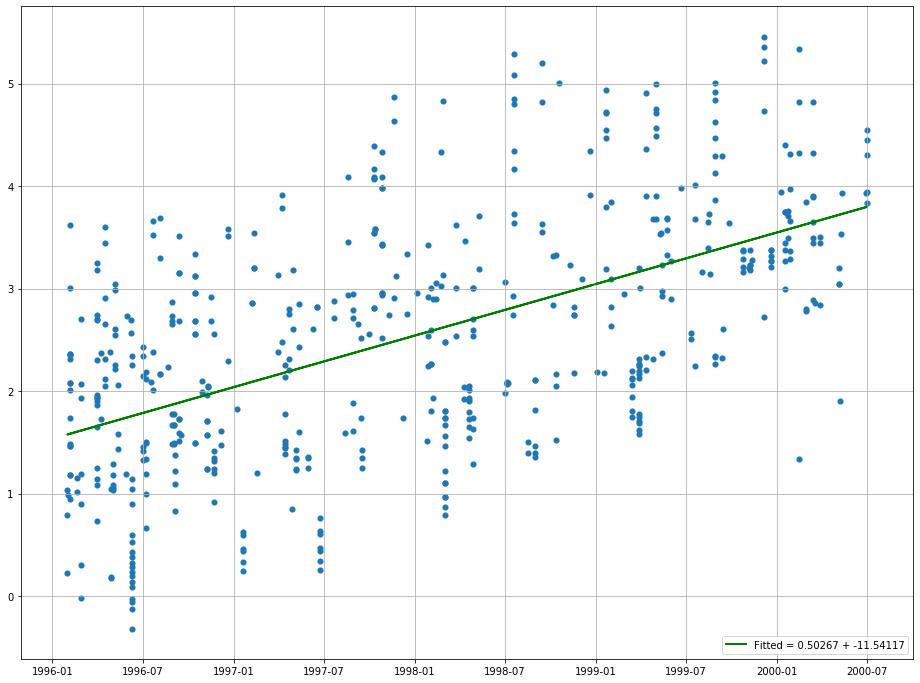

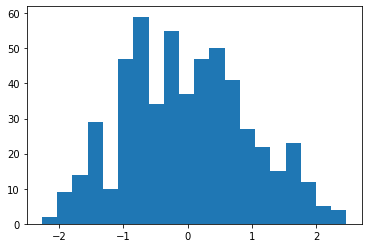

In [479]:
#initialize the model
reg = linear_model.LinearRegression()

#fit a linear regression
reg.fit(CleanDate, Base)

#predict the values
predicted = reg.predict(CleanDate)

#Get results
print(f'Coefficient = {reg.coef_[0][0]}.\nThis means every second the base increases by {math.e**reg.coef_[0][0]} \nOr every year, multiplies base by {math.e**(reg.coef_[0][0]*365*24*60*60)}')
print(f"R^2: {reg.score(CleanDate, Base)}")
print(f"MSE: {mean_squared_error(Base, predicted)}")

#convert the epoch dates back into readable years for plotting
yearDates = [datetime.fromtimestamp(time) for time in CleanDate]


#plot the results
plt.figure(figsize = (16,12))
plt.grid()
plt.scatter(yearDates, Base, lw = 0.1)
plt.plot(yearDates, reg.coef_[0][0]*CleanDate + reg.intercept_, color = 'green', label = f"Fitted = {round(reg.coef_[0][0]*365*24*60*60, 5)} + {round(reg.intercept_[0], 5)}", lw = 2)
plt.legend(loc = 'lower right')

#plot the residuals
#plotting residuals helps us to check for the linear regression assumption that errors are normally distributed.
plt.figure()
plt.hist(Base - predicted, bins = 20)

Moore's law states that the number of transistors in a will multiply every year. Colloquially, this has been interpreted as the speed of CPUs will double/increase every year. 
As shown in this example, the speed multiplies by 1.653 every year.

How to make this better: 
Randomly sample the different CPUs and get development of increases over time. I.e. does a CPU 95 have a bigger coefficient than one from 2006?
Get the mean and look at Moore's Law again. 

In [480]:
import string 

#combine all cpus and their benchmark
combo = []
for i in range(len(specs['testID'])):
    cpuentry = (specs['testID'][i].split("-")[0])
    
    #there are some entries starting with "p..." that do not include a date in the test ID
    #they are somewhat useless.
    if cpuentry[0] == 'c':
        combo.append(cpuentry + str("P") + specs["benchName"][i])

#select all the unique combinations of cpus and benchmarks
Different = pd.Series(combo).unique()

In [481]:
## define a cleaning function
def clean_it(cpu, benchMark):
    CleanDate = []
    Base = []

    for entry in range(len(specs['testID'])):

        #filter for the bench mark and the cpu we care about
        if cpu == specs['testID'][entry][0:len(cpu)] and benchMark == specs['benchName'][entry]:

            #extract the date from the test ID
            dirty_date = re.search('-(.*)-',specs['testID'][entry],re.IGNORECASE).group(1)

            #if the year is given in 19.. or 20.. format use "%Y%m%d"
            if dirty_date[0] == '1' or dirty_date[0] == '2': 
                date = datetime.strptime(dirty_date, "%Y%m%d").strftime('%s')
                CleanDate.append(int(date))

            #if the prefix is missing, we need to use "%y%m%d"
            else: 
                date = datetime.strptime(dirty_date, "%y%m%d").strftime('%s')
                CleanDate.append(int(date))

            ## record the relevant base 
            ## take the log of it. 
            Base.append(np.log(specs['base'][entry]))  
    return CleanDate, Base

In [482]:
#record the coefficients
multipliers = []
year = []

#for every unique combination
for specification in Different:
    
    #split the combinations back into cpu and benchmark
    seperate = re.split('P', specification)
    
    #use the cleaning function to clean the data
    CleanDate, Base = clean_it(seperate[0], seperate[1])
    
    ## There are some specs with just one measurement.
    #They break the regression
    if len(CleanDate) != 0 and len(Base) != 0:
        #reshape the data to fit with requirements for regression
        CleanDate = np.array(CleanDate).reshape(-1, 1)
        Base = np.array(Base).reshape(-1,1)
    else: 
        continue
    
    #define the linear regression
    reg = linear_model.LinearRegression()

    #fit a linear regression
    reg.fit(CleanDate, Base)
    
    #record how much the base is multiplied with each year.
    #we could record more measures (e.g. R^2), but for sake of Moore's Law, the multiplier is enough
    year.append((seperate[0][3:]))
    multipliers.append(math.e**(reg.coef_[0][0]*365*24*60*60))

Mean multiplier 1.3917383932507108
95% Confidence Interval: [1.09258698 1.09599756]
Minimum multiplier: 1.0923975076481394
Regression coefficient of multiplier = year + e: -0.00013049243465417936


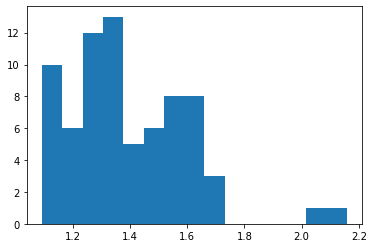

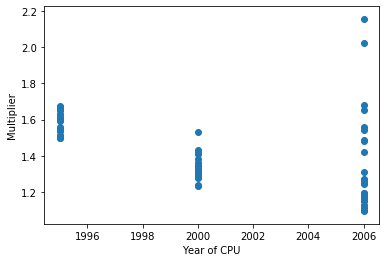

In [483]:
#plot the distribution
plt.hist(multipliers,15)

years =[]

for dirty_year in year:
    if dirty_year[0] == '1' or dirty_year[0] == '2': 
        date = datetime.strptime(dirty_year, "%Y").strftime('%Y')
        years.append(int(date))

        #if the prefix is missing, we need to use "%y%m%d"
    else: 
        date = datetime.strptime(dirty_year, "%y").strftime('%Y')
        years.append(int(date))

#find the mean and confidence interval
plt.figure()
print(f"Mean multiplier {np.mean(multipliers)}")
plt.scatter(years, multipliers)
plt.xlabel("Year of CPU")
plt.ylabel("Multiplier")
print(f"95% Confidence Interval: {np.percentile(multipliers, (0.05, 0.95))}")
print(f"Minimum multiplier: {min(multipliers)}")

#estimating the change in multiplier per year
reg = reg = linear_model.LinearRegression()

#fit a linear regression
reg.fit((np.array(year).astype(np.float64)).reshape(-1,1), (np.array(multipliers).astype(np.float64)).reshape(-1,1))

print(f"Regression coefficient of multiplier = year + e: {reg.coef_[0][0]}")

With the minimum multiplier being > 1, we see an increase in all the different combinations and specifications. They are distributed with higher multipliers being less likely then higher ones. From the graph of years vs. multiplier it appears like the rate of improvement has been decreasing. However, running a quick linear regression (heavily influence by the high outliers in 2006) reveals that this trend is almost non-existent. 

#### Ultimately
Moore does seem to be right that we will improve our computational speeds.

## MNIST Digits

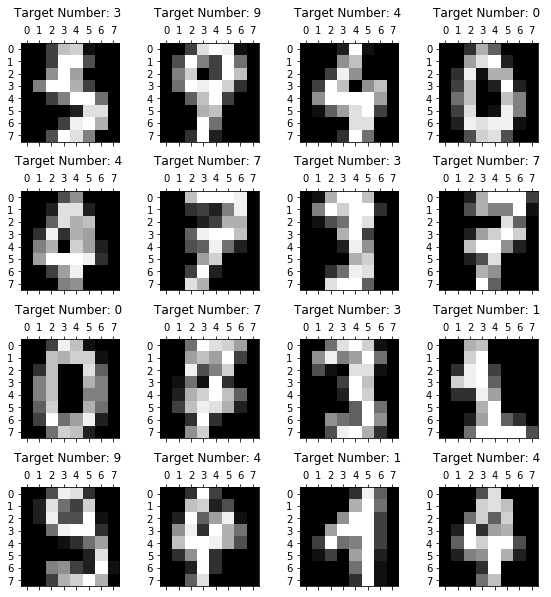

In [485]:
## Load the dataset + visualize some of the dataset

digits = load_digits()


#configure the subplots
fig, axs = plt.subplots(4,4, figsize=(10,10))
fig.subplots_adjust(hspace = .5, wspace=.001)

axs = axs.ravel()

#plot 16 different examples with their target number on top.
for i in range(16):
    rd.seed(i)
    access = rd.randint(0,len(digits.images))
    axs[i].matshow(digits.images[access])
    axs[i].set_title(f"Target Number: {digits.target[access]} \n")

In [486]:
## Use a KNN classifier

def knn_with_cross_val(dataset, targetNumbers):
    
    """
    func: knn_with_cross_val
    input:   - dataset: in our case the digits dataset 
             - targetNumbers: list of numbers to be classified. E.g. [1, 7]
    
    """
    print(f"Identifying Numbers {targetNumbers}")
    
    #filter out the input and targets for the selected numbers
    info = []
    targets = []
    
    #go through each digit: 
    for i in range(len(dataset.data)):
        
        #if the target is one of the numbers
        if digits.target[i] in targetNumbers:
            
            #add its info and the target to the input and target list
            info.append(dataset.data[i])
            targets.append(dataset.target[i])
            
    # split data 
    (info_train, info_test, target_train, target_test) = train_test_split(info,
        targets, test_size=0.15, random_state=42)

    #initialize the parameters
    k_score = 0
    max_score = -1
    k_testing = 0
    
    
    #iterate over different ks until there is no improvement
    while max_score < k_score:

        #update the max score
        max_score = k_score
        
        #increase potential k 
        k_testing += 1
        
        #create k nearest neighbor classifier
        validation = KNeighborsClassifier(n_neighbors = k_testing)
        #train the model
        validation.fit(info_train, target_train)

        #Cross validate with Leave one out (by setting the number of folds to the length of the data set)
        score = cross_val_score(validation, info_train, target_train, cv = 20)
        
        #Calculate and output score to the current max score
        k_score = np.mean(score)
        print(f"Using {k_testing} neighbor has cross-val score = {k_score}")
    
    #go back to the best k (assumption of unimodal optimal k)
    k_testing -= 1
    print(f"We will be using {k_testing} neighbors with mean cross-validation score {k_score}") 
    
    #using the best k
    max_score_k = k_testing

    #re-train the model with the best k
    knn_train_model = KNeighborsClassifier(n_neighbors = max_score_k)
    knn_train_model.fit(info_train, target_train)

    #make predictions on the test data
    target_pred = knn_train_model.predict(info_test)
    
    
    # a report of performance on the test set
    print(f'\n Using the test data we report:')
    print(classification_report(target_test, target_pred))
    
    # Plot confusion matrix
    sns.heatmap(confusion_matrix(target_test, target_pred),annot=True,cbar=True)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')


    return "Done."

Identifying Numbers [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Using 1 neighbor has cross-val score = 0.9887336140574536
Using 2 neighbor has cross-val score = 0.9867603645196501
We will be using 1 neighbors with mean cross-validation score 0.9867603645196501

 Using the test data we report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        23
           1       0.90      1.00      0.95        18
           2       1.00      1.00      1.00        26
           3       0.96      1.00      0.98        24
           4       0.97      0.97      0.97        37
           5       0.97      1.00      0.99        33
           6       1.00      1.00      1.00        30
           7       1.00      0.96      0.98        26
           8       1.00      0.89      0.94        19
           9       0.94      0.91      0.93        34

    accuracy                           0.97       270
   macro avg       0.97      0.97      0.97       270
weighted avg   

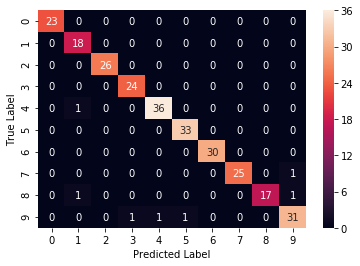

In [487]:
#run the function with all the digits
print(knn_with_cross_val(digits, [0,1,2,3,4,5,6,7,8,9]))

As shown in the confusion matrix, the overall hardest to classify number is 9 with the f1 score of 0.93 (combination of recall and precision). "1", has the worst precision score (i.e., with 10% of 1s wrongly as being a 1). This is, however driven by the fact that there are only 18 of them. Number 9, overall, does worse especially because only 91% of 9s are identified as being a 9.